In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
def build_model(input_size, output_size,learning_rate,final_activation,nodes):
    model = Sequential()
    model.add(Dense(nodes, input_dim=input_size, activation="relu"))
    model.add(Dense(nodes, activation="relu"))
    model.add(Dense(nodes, activation="relu"))
    model.add(Dense(output_size, activation='linear'))
    if final_activation is not None:
        model.add(final_activation)
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate))
    return model

In [ ]:
def plot_results(x,y,x_label,y_label,title):
    """
    Plot results for each function
    :param x: [] list of values to display along X axis
    :param y: [] list of values to display  along Y axis
    :param x_label: Str name of the x axis
    :param y_label: Str name of the y axis
    :param title : Str title of the chart
    """
    plt.plot(x,y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.close()

In [ ]:
def QlearningNN(env, epsilon_decay, discount, epsilon, min_eps, episodes, model, other_stats):
    local_stats = {'reached_goal': 0, 'current_moves': 0, 'moves_to_success': [], 'highest_position': -1.2,
                   'largest_velocity': -0.07}

    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []

    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0, 0
        state = env.reset()

        steps = 0
        while done != True:
            # Render environment for last five episodes
            # if i >= (episodes - 20):
            #    env.render()
            steps += 1
            # Decrease epsilon up to epsilon_decay value 
            epsilon *= epsilon_decay
            epsilon = max(min_eps, epsilon)
            Q = model.predict(state.reshape(1, len(state)))
            # Determine next action based on epsilon 
            if np.random.rand() <= epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q)

            # Get next state and reward
            state2, reward, done, info = env.step(action)

            if (state2[0] > local_stats['highest_position']):
                local_stats['highest_position'] = state2[0]

            if (state2[1] > local_stats['largest_velocity']):
                local_stats['largest_velocity'] = state2[1]

            # Count only moves
            if action != 1:
                local_stats['current_moves'] += 1

            # Check if we reached the goal 
            if done and state2[0] >= 0.5:
                local_stats['reached_goal'] += 1
                local_stats['moves_to_success'].append(local_stats['current_moves'])
                local_stats['current_moves'] = 0
                target = reward


            # Adjust Q value for current state
            else:
                pred = model.predict(state2.reshape(1, len(state2)))
                Q_next = np.max(pred)
                target = reward + Q_next * discount

            Q[0][action] = target
            tot_reward += reward

            if steps > 199:
                done = True

            # Train model with state and action 
            model.fit(x=state.reshape(1, len(state)), y=Q, epochs=1, verbose=0)

        # Track rewards
        reward_list.append(tot_reward)

        if (i + 1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            other_stats['reached_goal_episodes'].append(local_stats['reached_goal'])
            other_stats['highest_positions'].append(local_stats['highest_position'])
            other_stats['largest_velocities'].append(local_stats['largest_velocity'])
            if (len(local_stats['moves_to_success']) > 0):
                other_stats['ave_moves_to_success'].append(np.mean(local_stats['moves_to_success']))
            else:
                other_stats['ave_moves_to_success'].append(0)
            local_stats = {'reached_goal': 0, 'current_moves': 0, 'moves_to_success': [], 'highest_position': -1.2,
                           'largest_velocity': -0.07}

        if (i + 1) % 100 == 0:
            print('Episode {} Average Reward: {}'.format(i + 1, ave_reward))

    env.close()
    return ave_reward_list, other_stats

## Initialize model with initial parameters

In [ ]:
env = gym.make('MountainCar-v0')
env.reset()
#Initialize dictionary to collect statistics
other_stats = {'reached_goal_episodes':[], 'ave_moves_to_success':[],'highest_positions':[], 'largest_velocities':[]}
model = build_model(env.observation_space.shape[0],env.action_space.n,0.005,None,20)
rewards,other_stats = QlearningNN(env, 0.95, 0.85, 1, 0.01, 2000,model,other_stats)





/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100 Average Reward: -199.69
Episode 200 Average Reward: -199.8
Episode 300 Average Reward: -198.98
Episode 400 Average Reward: -198.24
Episode 500 Average Reward: -199.16
Episode 600 Average Reward: -199.38
Episode 700 Average Reward: -200.0


### Display main statistics as for DP method

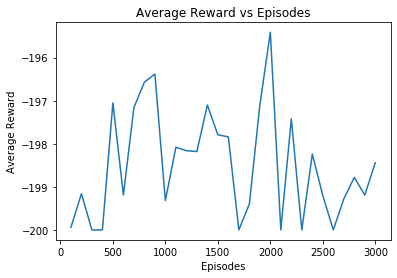

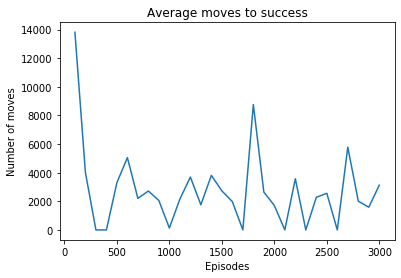

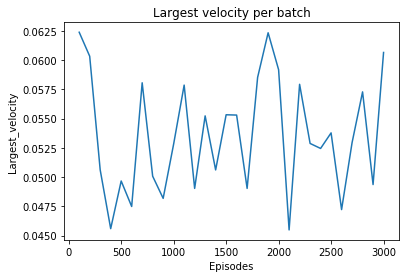

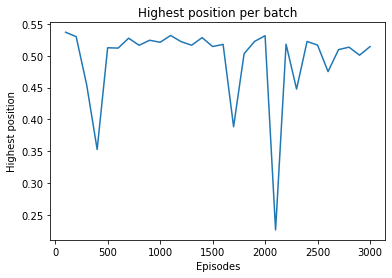

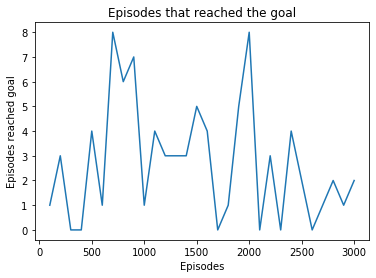

In [ ]:
episodes = 100*(np.arange(len(rewards)) + 1)
episodes2  = 100*(np.arange(len(other_stats['ave_moves_to_success'])) + 1)
plot_results(episodes,rewards, 'Episodes','Average Reward','Average Reward vs Episodes')
plot_results(episodes2,other_stats['ave_moves_to_success'], 'Episodes','Number of moves','Average moves to success')
plot_results(episodes2,other_stats['largest_velocities'], 'Episodes','Largest_velocity','Largest velocity per batch')
plot_results(episodes2,other_stats['highest_positions'], 'Episodes','Highest position','Highest position per batch')
plot_results(episodes2,other_stats['reached_goal_episodes'], 'Episodes','Episodes reached goal','Episodes that reached the goal')




### Try different model configurations

#### Explore number of nodes

In [ ]:
node_options = [2, 5, 10, 20, 40]
reward_per_option = {}
for node in node_options:
    reward_per_option[node] = []

for node in node_options:
    model = build_model(env.observation_space.shape[0],env.action_space.n,0.005,None,node)
    rewards,other_stats = QlearningNN(env, 0.995, 0.85, 1, 0.01, 1000,model,other_stats)
    reward_per_option[node] = rewards

df = pd.DataFrame(reward_per_option)
ax = plt.gca()
for node in node_options:
    df.plot(y=node,ax=ax,title="Explore  number of nodes per layer")


Episode 10 Average Reward: -200.0
Episode 20 Average Reward: -200.0
Episode 30 Average Reward: -200.0
Episode 40 Average Reward: -200.0
Episode 50 Average Reward: -200.0
Episode 60 Average Reward: -200.0


KeyboardInterrupt: ignored

#### Explore learning rate

In [ ]:
lr_options = [0.0001,0.0005,0.001,0.1,0.15]
reward_per_option = {}
for lr in lr_options:
    reward_per_option[lr] = []

for lr in lr_options:
    model = build_model(env.observation_space.shape[0],env.action_space.n,lr,None,20)
    rewards,other_stats = QlearningNN(env, 0.995, 0.85, 1, 0.01, 1000,model,other_stats)
    reward_per_option[lr] = rewards

df = pd.DataFrame(reward_per_option)
ax = plt.gca()
for lr in lr_options:
    df.plot(y=lr,ax=ax,title="Explore learning rate values")


#### Explore final activations

#####  Check for advanced activation functions

In [ ]:
from keras.layers.advanced_activations import LeakyReLU, PReLU
activation_options = [LeakyReLU(alpha=.001), PReLU()]
activation_option_names = ['leaky_relu', 'prelu']

for activation in activation_option_names:
    reward_per_option[activation] = []

for i in range(0,2):
    activation = activation_options[i]
    activation_name = activation_option_names[i]
    model = build_model(env.observation_space.shape[0],env.action_space.n,0.005,activation,20)
    rewards,other_stats = QlearningNN(env, 0.995, 0.85, 1, 0.01, 1000,model,other_stats)
    reward_per_option[activation_name] = rewards

df = pd.DataFrame(reward_per_option)
ax = plt.gca()
for activation_name in activation_option_names:
    df.p